# Learning the Wave Equation

See the library `nn_1d_pde` for more on this problem.

In [105]:
import numpy as np
from matplotlib import pylab as plt
from matplotlib import cm
plt.style.use('seaborn-paper')
import detest
import sympy

In [ ]:
import utils
import plotting
import helper
import models
# Hack for reloading in notebooks without reseting the kernel
import importlib
importlib.reload(utils)
importlib.reload(helper)
importlib.reload(plotting)
importlib.reload(models)

from helper import *
from utils import *
from analytical_solutions import *

In [77]:
# A few preset interesting functions
PAR = [
    {},
    {'u0':lambda x: -x**3+x},
    {'u0':lambda x: sympy.sin(2.0*x*sympy.pi)},
    {'u0':lambda x: sympy.sin(4.0*x*sympy.pi)},
    {'u0':lambda x: sympy.sin(3.0*x*sympy.pi)+sympy.sin(4.0*x*sympy.pi)},
    {'u0':lambda x: sympy.sin(2.0*x*sympy.pi)+sympy.sin(4.0*x*sympy.pi)},
    {'u0':lambda x: sympy.sin(2.0*x*sympy.pi)+sympy.sin(8.0*x*sympy.pi)},
    {'u0':lambda x: 10.0*(x-x**2)},
    {'u0':lambda x: 15.0*(-x+x**2)},
    {'u0':lambda x: -x**3+x**2},
]

In [78]:
def make_wave_dataset(NX,NT, params={}):
    """Returns a numpy array with dimensions (N_time=NT, N_channel=2, N_space=NX)"""
    xs = np.linspace(0,1,NX)
    ts = np.linspace(0,5,NT)
    grid = np.meshgrid(xs,ts)
    orc = detest.oracles.WaveEquation1D(params)
    res = orc(np.c_[grid[0].ravel(),grid[1].ravel()])

    for k in res.keys():
        res[k] = res[k].reshape(NT,1,NX)
    return np.concatenate([res['u'],res['v']], axis=1)

In [101]:
data = make_wave_dataset(10,25,params=PAR[1])

[0.19350920659919693, -0.024188650824899606, 0.007167007651822101, -0.0030235813531124464, 0.0015480736527935708, -0.0008958759564777596, 0.0005641667830880341, -0.00037794766913905347, 0.00026544472784526056, -0.00019350920659919448, 0.00014538633102868976, -0.00011198449455971839, 8.807883777842609e-05, -7.052084788600294e-05, 5.733606121457203e-05, -4.724345864238052e-05, 3.9387178220883785e-05, -3.318059098065654e-05, 2.8212451756695488e-05, -2.418865082489838e-05]


In [102]:
NT,_,NX = data.shape
data.shape

(25, 2, 10)

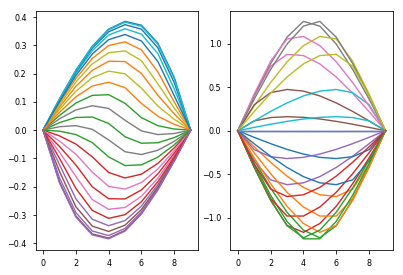

In [271]:
plt.subplot(1,2,1)
for i in range(NT):
    plt.plot(data[i,0,:])
plt.subplot(1,2,2)
for i in range(NT):
    plt.plot(data[i,1,:])

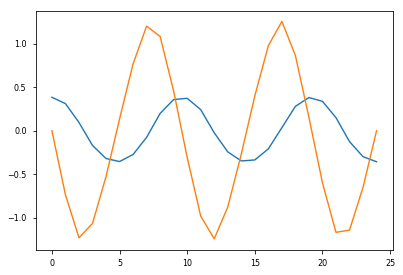

In [107]:
plt.plot(data[:,0,NX//2])
plt.plot(data[:,1,NX//2])

In [113]:
device=get_device()
set_seed()

Using the CPU


In [114]:
torch_data = data_to_torch(data, device=device)

In [211]:
import functools

In [242]:
class MultiLinear(torch.nn.Module):
    """Like Linear, but allows for higher ranks."""
    def __init__(self, in_dims, out_dims, bias=True):
        super(MultiLinear, self).__init__()
        self.in_dims = in_dims
        self.out_dims = out_dims
        in_features = functools.reduce(lambda x,y:x*y, in_dims)
        out_features = functools.reduce(lambda x,y:x*y, out_dims)
        self.net = torch.nn.Linear(in_features, out_features, bias=bias)
    def forward(self, x):
        xflat = torch.flatten(x, start_dim=-len(self.in_dims))
        hflat = self.net(xflat)
        return torch.reshape( hflat, hflat.shape[:-1]+self.out_dims )

In [243]:
model = MultiLinear((2,NX),(2,NX),bias=False).double()

In [244]:
torch_data.shape

torch.Size([25, 2, 10])

In [315]:
_,losses=learn_rnn(torch_data, model, N_iter=50000, batch_size=50)

Using the CPU


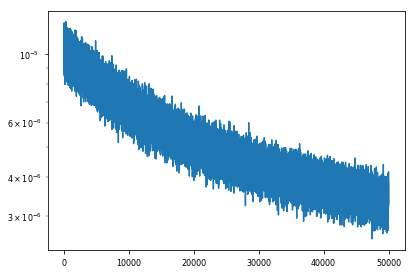

In [316]:
plt.semilogy(losses)

In [317]:
def integrate_model(step_func, u0, nsteps):
    with torch.no_grad():
        us = [u0.cpu().numpy()]
        for i in range(nsteps):
            un = step_func(u0)
            us.append(un.cpu().numpy())
            u0 = un
        U = np.array(us).reshape((-1,)+ u0.shape[1:])
    return U

In [318]:
UV = integrate_model(model, torch_data[0:1,:,:],nsteps=25)

In [319]:
UV.shape

(26, 2, 10)

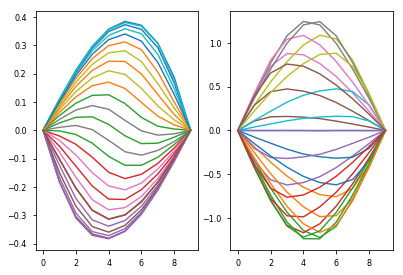

In [320]:
plt.subplot(1,2,1)
for i in range(UV.shape[0]):
    plt.plot(UV[i,0,:])
plt.subplot(1,2,2)
for i in range(UV.shape[0]):
    plt.plot(UV[i,1,:])

In [321]:
Omega = model.net.weight.detach().cpu().numpy()

In [322]:
w,V = np.linalg.eig(Omega)

In [323]:
Lambda = V.dot( np.diag(np.log(w)).dot(np.linalg.inv(V)))
Lambda = np.array(Lambda,dtype=np.double)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [324]:
Lambda

array([[-4.94009654e+00, -1.12843132e-01,  2.35528460e-01,
        -3.21347895e-01,  3.32976144e-01, -2.92090206e-01,
         1.94931341e-01, -6.25575869e-02, -1.03183270e-02,
         9.29736011e-02,  4.46430124e-01, -7.37839534e-02,
         1.26922676e-01, -1.35918103e-01,  9.61444477e-02,
        -2.59270839e-02, -4.51890945e-02,  7.70550334e-02,
        -5.34872304e-02, -3.79035332e+00],
       [-3.51307150e-01, -2.89813264e-02,  2.56798233e-04,
         2.46853136e-02, -3.58031311e-02,  6.92493750e-02,
        -1.94516378e-01,  3.90212591e-01, -3.70010826e-01,
         3.73487455e-01, -2.85093777e-01, -2.93136695e-01,
         7.97223302e-01, -1.15078211e-01, -4.86778837e-01,
         2.16051811e-01,  2.22274923e-02,  1.83120161e-01,
        -3.25339299e-01, -4.27439920e-01],
       [ 9.81691156e-01,  1.25639613e-01, -2.86934436e-01,
         3.51857691e-01, -1.78130579e-01, -1.01588893e-01,
         3.27676899e-01, -4.79635178e-01,  3.99556236e-01,
         1.93126447e-02, -2.3

In [325]:
np.linalg.eig?

Signature: np.linalg.eig(a)
Docstring:
Compute the eigenvalues and right eigenvectors of a square array.

Parameters
----------
a : (..., M, M) array
    Matrices for which the eigenvalues and right eigenvectors will
    be computed

Returns
-------
w : (..., M) array
    The eigenvalues, each repeated according to its multiplicity.
    The eigenvalues are not necessarily ordered. The resulting
    array will be of complex type, unless the imaginary part is
    zero in which case it will be cast to a real type. When `a`
    is real the resulting eigenvalues will be real (0 imaginary
    part) or occur in conjugate pairs

v : (..., M, M) array
    The normalized (unit "length") eigenvectors, such that the
    column ``v[:,i]`` is the eigenvector corresponding to the
    eigenvalue ``w[i]``.

Raises
------
LinAlgError
    If the eigenvalue computation does not converge.

See Also
--------
eigvals : eigenvalues of a non-symmetric array.

eigh : eigenvalues and eigenvectors of a symmetric 

In [328]:
import seaborn

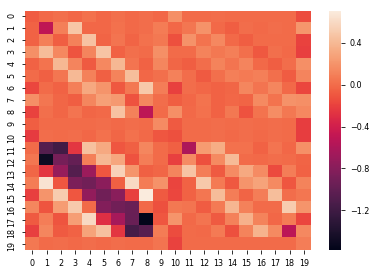

In [329]:
seaborn.heatmap(Omega)

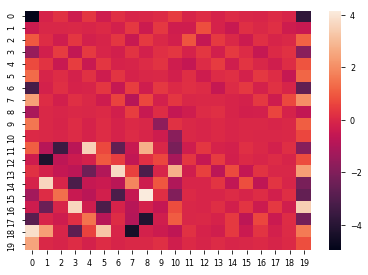

In [330]:
seaborn.heatmap(Lambda)